In [1]:

import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

torch.manual_seed(42)
random.seed(42)


In [2]:

loaded_x = np.load("Data/data_x.npz", allow_pickle=True)
dict_x = {key: loaded_x[key] for key in loaded_x.files}

loaded_y = np.load("Data/data_y.npz", allow_pickle=True)
dict_y = {key: loaded_y[key] for key in loaded_y.files}


In [3]:

all_keys = list(dict_x.keys())
random.shuffle(all_keys)

split_index = int(len(all_keys) * 0.8)
train_keys = all_keys[:split_index]
valid_keys = all_keys[split_index:]

data_train_x = np.vstack([dict_x[k] for k in train_keys]) 
data_train_x = np.nan_to_num(data_train_x, nan=0.0)
data_valid_x = np.vstack([dict_x[k] for k in valid_keys])
data_valid_x = np.nan_to_num(data_valid_x, nan=0.0)
data_x = np.vstack([dict_x[k] for k in all_keys])

data_train_y = np.concatenate([dict_y[k] for k in train_keys]) 
data_train_y = np.nan_to_num(data_train_y, nan=0.0)
data_valid_y = np.concatenate([dict_y[k] for k in valid_keys]) 
data_valid_y = np.nan_to_num(data_valid_y, nan=0.0)
data_y = np.concatenate([dict_y[k] for k in all_keys])

print(data_valid_x.shape, data_valid_y.shape)
print(data_train_x.shape, data_train_y.shape)
print(data_x.shape, data_y.shape)


(624, 3, 28) (624, 1)
(2496, 3, 28) (2496, 1)
(3120, 3, 28) (3120, 1)


In [4]:
data_y

array([[0.17709823],
       [0.1756595 ],
       [0.17854647],
       ...,
       [0.22161508],
       [0.22055228],
       [0.21017799]])

In [5]:
data_train_x = torch.tensor(data_train_x, dtype=torch.float32)
data_train_y = torch.tensor(data_train_y, dtype=torch.float32).unsqueeze(1)
data_valid_x = torch.tensor(data_valid_x, dtype=torch.float32)
data_valid_y = torch.tensor(data_valid_y, dtype=torch.float32).unsqueeze(1)
data_x = torch.tensor(data_x, dtype=torch.float32)
data_y = torch.tensor(data_y, dtype=torch.float32).unsqueeze(1)


In [6]:

batch_size = data_train_x.shape[0]

dataset_train = TensorDataset(data_train_x, data_train_y)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=5) 
dataset_valid = TensorDataset(data_valid_x, data_valid_y)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, num_workers=5) 


In [7]:
class RNN_Regressor(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        lstm_hidden_size = 16
        hidden_size1 = 8
        hidden_size2 = 8

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, batch_first=True)

        self.dense1 = nn.Linear(lstm_hidden_size, hidden_size1)
        self.dense2 = nn.Linear(hidden_size1, hidden_size2)
        self.dense3 = nn.Linear(hidden_size2, output_size)

        

    def forward(self, input):
        x = F.dropout(input, p=0.0)

        x, _ = self.lstm(x)
        x = x[:, -1, :]

        x = self.dense1(x)
        x = F.gelu(x)

        # x = self.dense2(x)
        # x = F.gelu(x)

        x = self.dense3(x)
        x = F.sigmoid(x)

        return x



     


In [21]:
output_num = 1
model = RNN_Regressor(data_train_x.shape[2], output_num)

optimizer = optim.Adam(model.parameters(), lr=0.008, weight_decay=0.00001)
criterion = nn.MSELoss()

history = {
    "train_loss": [],
    "valid_loss": []
}


In [22]:

max_epochs = 100

for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in dataloader_train:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    history["train_loss"].append(running_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in dataloader_valid:
            val_outputs = model(x_batch)
            val_loss = criterion(val_outputs, y_batch)
            running_val_loss += val_loss.item()

    history["valid_loss"].append(running_val_loss)

    print(f"Epoch [{epoch+1}/{max_epochs}], Training Loss: {history['train_loss'][-1]:.5f}, Validation Loss: {history['valid_loss'][-1]:.5f}")



     


Epoch [1/100], Training Loss: 0.04353, Validation Loss: 0.04445
Epoch [2/100], Training Loss: 0.03951, Validation Loss: 0.04050
Epoch [3/100], Training Loss: 0.03584, Validation Loss: 0.03668
Epoch [4/100], Training Loss: 0.03233, Validation Loss: 0.03293
Epoch [5/100], Training Loss: 0.02889, Validation Loss: 0.02925
Epoch [6/100], Training Loss: 0.02554, Validation Loss: 0.02570
Epoch [7/100], Training Loss: 0.02235, Validation Loss: 0.02235
Epoch [8/100], Training Loss: 0.01941, Validation Loss: 0.01929
Epoch [9/100], Training Loss: 0.01680, Validation Loss: 0.01660
Epoch [10/100], Training Loss: 0.01459, Validation Loss: 0.01436
Epoch [11/100], Training Loss: 0.01287, Validation Loss: 0.01263
Epoch [12/100], Training Loss: 0.01166, Validation Loss: 0.01142
Epoch [13/100], Training Loss: 0.01097, Validation Loss: 0.01067
Epoch [14/100], Training Loss: 0.01071, Validation Loss: 0.01026
Epoch [15/100], Training Loss: 0.01073, Validation Loss: 0.01005
Epoch [16/100], Training Loss: 0.0

In [10]:
data_train_y[:,0,:].shape

torch.Size([2496, 1])

In [23]:
model.eval()
with torch.no_grad(): 
    output = model(data_train_x)

for i in range(output_num):
    print(r2_score(data_train_y[:,0,i], output[:,i]))

0.004151184812208553


In [24]:
model.eval()
with torch.no_grad(): 
    output = model(data_valid_x)

for i in range(output_num):
    print(r2_score(data_valid_y[:,0,i], output[:,i]))

-0.03168880511058281


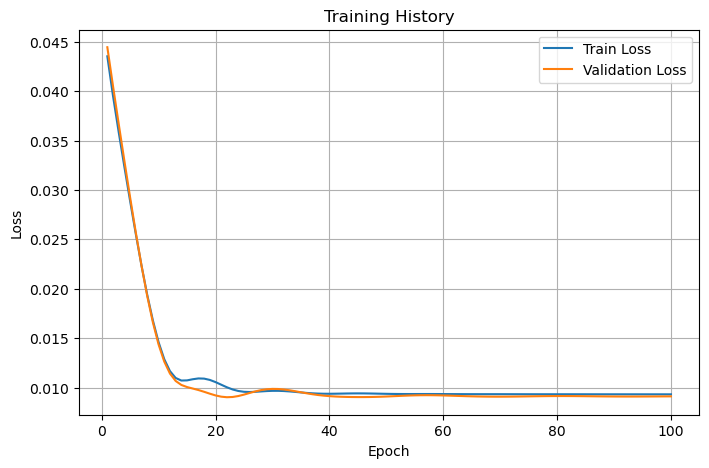

In [25]:


train_loss = history["train_loss"]
valid_loss = history["valid_loss"]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Train Loss")
epochs = range(1, len(valid_loss) + 1)
plt.plot(epochs, valid_loss, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training History")
plt.legend()
plt.grid(True)



     


In [ ]:
print(torch.isnan(data_train_x).any(), torch.isinf(data_train_x).any())
print(torch.isnan(data_train_y).any(), torch.isinf(data_train_y).any())


tensor(False) tensor(False)
tensor(False) tensor(False)


In [ ]:
data_train_x

tensor([[[-1.4382, -1.3876, -1.4177,  ..., -0.5325, -0.5593, -0.4062],
         [-1.3934, -1.3545, -1.3784,  ..., -0.5353, -0.5157, -0.3924],
         [-1.2155, -1.2862, -1.2524,  ..., -0.5667, -0.5021, -0.3560]],

        [[-1.3934, -1.3545, -1.3784,  ..., -0.5353, -0.5157, -0.3924],
         [-1.2155, -1.2862, -1.2524,  ..., -0.5667, -0.5021, -0.3560],
         [-1.1148, -1.2156, -1.1657,  ..., -0.4991, -0.4847, -0.2723]],

        [[-1.2155, -1.2862, -1.2524,  ..., -0.5667, -0.5021, -0.3560],
         [-1.1148, -1.2156, -1.1657,  ..., -0.4991, -0.4847, -0.2723],
         [-1.0709, -1.1557, -1.1144,  ..., -0.4493, -0.4826, -0.2149]],

        ...,

        [[-0.8211, -0.7098, -0.7701,  ..., -0.5426, -0.7734, -0.6289],
         [-0.8090, -0.6864, -0.7526,  ..., -0.4651, -0.8140, -0.5658],
         [-0.7855, -0.6505, -0.7231,  ..., -0.5815, -0.8589, -0.5389]],

        [[-0.8090, -0.6864, -0.7526,  ..., -0.4651, -0.8140, -0.5658],
         [-0.7855, -0.6505, -0.7231,  ..., -0.5815, -0.

In [ ]:
data_train_x[torch.where(torch.isnan(data_train_x))]

tensor([])

In [ ]:
nancoords = torch.where(torch.isnan(data_train_x))

In [ ]:
data_train_x.shape

torch.Size([2496, 3, 27])

In [ ]:
len(train_keys)

312

In [ ]:
len(all_keys)

390

In [ ]:
batch_size

2496

In [ ]:
for i, key in enumerate(train_keys):
    arr = dict_x[key]
    if np.isnan(arr).any():
        print(key)
        print(f"\nKey: {key}\nArray:\n{arr}")
        print(np.where(np.isnan(arr)))
        print(arr.shape)
        print(arr[np.where(np.isnan(arr))])
        coords = np.where(np.isnan(arr))
        print(arr[coords[0][0], coords[1][0], coords[2][0]])
        print(coords[0][0], coords[1][0], coords[2][0])
        print(arr[1, 2, 13])

        


In [ ]:
arr = dict_x["16072"]
np.isnan(arr[1,2,13])

False